In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch import optim, nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from numpy import genfromtxt
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb


import copy
%matplotlib inline

rng = 0

drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Colab\ Notebooks

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


Load data   
Split the dataset by city,drop 'week_start_date' since we don't need such fine-grained time data .  
Check missing data.

In [ ]:
train_features = pd.read_csv("./dengue_features_train.csv")
train_labels = pd.read_csv("./dengue_labels_train.csv")
test_features=pd.read_csv("./dengue_features_test.csv")

sj_train_features=train_features[train_features.city=='sj']
sj_train_features.drop(['city','week_start_date'],axis=1, inplace=True)

sj_train_labels=train_labels[train_labels.city=='sj']
sj_train_labels.drop(['city','year','weekofyear'],axis=1, inplace=True)

print('\n San Juan any nulls?')
print(pd.isnull(sj_train_features).any())
print(pd.isna(sj_train_features).any())
print(pd.isnull(sj_train_labels).any())
print(pd.isna(sj_train_labels).any())


 San Juan any nulls?
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_temp_c                    

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Classification

We want to divide the categories based on quartiles. Because quartiles can help us identify different levels of data and outliers. 

In [ ]:
sj_train_labels.describe()

,total_cases
count,936.000000
mean,34.180556
std,51.381372
min,0.000000
25%,9.000000
50%,19.000000
75%,37.000000
max,461.000000


Draw graphs to see the distribution of totol_cases.   
We can see that most of the data are between 0-50. And in the box plot, data points greater than upper edge are outliers. 

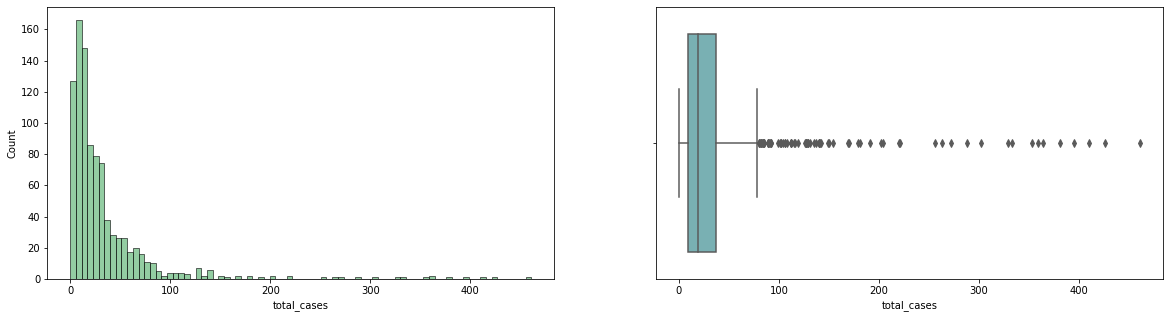

In [ ]:
 _, axs = plt.subplots(1, 2,figsize=(20, 5))
sns.histplot(x=sj_train_labels['total_cases'],kde=False,color='#65b87b', alpha=.7,ax=axs[0])
sns.boxplot(x=sj_train_labels['total_cases'],color='#6fb9bd',ax=axs[1])

We calculate the upper edge using quartiles. Upper edge is the non-anomalous maximum.  
We think that data should be ranged as (lower edge,q1),(q1,q3),(q3,upper edge),(upper edge,).These categories correspond to lower values, intermediate values, higher values, and outliers.  

In [ ]:
#In boxplot, data is divided by: lower--q1--(q2)--q3--upper---
q1=9
q2=19
q3=37
lower=q1-(1.5*(q3-q1)) if q1-(1.5*(q3-q1))>0 else 0 #Non-anomalous minimum,lower edge of boxplot
upper=q3+(1.5*(q3-q1)) #Non-anomalous maximum,upper edge of boxplot. outlier= data > upper

Logic by using a static algorithm to sort the labels into range_groups

In [ ]:
def get_range_group_from_cases(cases):
    if cases<q1:
        return 0
    elif cases<q3:
        return 1
    elif cases <upper:
        return 2
    else:
        return 3

Knn imputer to impute missing features to values closer to them of the same cluster.


In [ ]:
knnImputer = KNNImputer(n_neighbors=4,
                        weights="distance",
                        copy=False)
sj_train_features = knnImputer.fit_transform(sj_train_features)

After preprocessing,transform data to tensor type.

In [ ]:

sj_train_features_t=torch.tensor(sj_train_features,dtype=torch.float)
sj_train_labels_t=torch.tensor(sj_train_labels.to_numpy(),dtype=torch.float).view(-1,1)

Initialise neural network linearly.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(22,15)# 15 seems to work better than 10
        self.layer2 = nn.Linear(15,4)
        # self.layer3 = nn.Linear(9,4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        return x


Training NN model.

ADAM optimizer is used for it's stochastic gradient descent method to update biases

Backpropagation is also used.

Cross Entropy loss is used for classification problem.It supports labels in long type.

In [ ]:
def train_net(net,
          train_features,
          train_labels,
          test_features=None,
          test_labels=None,
          num_epochs = 10,
          learning_rate=0.1,
          batch_size=10):
    train_ls=[] 
    dataset=TensorDataset(train_features,train_labels)
    train_iter=DataLoader(dataset,batch_size,shuffle=True)
    optimizer=optim.Adam(params=net.parameters(),
                         lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    net=net.float()
    for epoch in range(num_epochs):
        for x , y in train_iter:
            optimizer.zero_grad()
            output=net(x.float())
            loss=criterion(output,y)
            loss.backward()
            optimizer.step()
        print("loss: {}".format(loss))
    

In [ ]:
net = Net()

Changed y values in test from number of cases to cluster number

train_features_in_range_groups save the features of different cluster.  
train_labels_in_range_groups save the total_cases of differnet cluser.  
y_range_groups save the cluster number of each input data. 

In [ ]:
sj_train_labels = sj_train_labels.total_cases
y_range_groups = torch.tensor(sj_train_labels)
train_features_in_range_groups = [[],[],[],[]]
train_labels_in_range_groups = [[],[],[],[]]
for i,y in enumerate(sj_train_labels):
  range_group = get_range_group_from_cases(int(y))
  range_group = torch.tensor([range_group])
  
  train_features_in_range_groups[range_group].append(sj_train_features[i]) 
  train_labels_in_range_groups[range_group].append(sj_train_labels[i])
  y_range_groups[i] = range_group

Train NN.

In [ ]:
train_net(net=net,num_epochs=20,
                 train_features=sj_train_features_t,
                 train_labels=y_range_groups)

loss: 62.902400970458984
loss: 2.2867653369903564
loss: 0.9966108798980713
loss: 1.2429308891296387
loss: 2.9608070850372314
loss: 2.507720708847046
loss: 1.3941351175308228
loss: 145.21734619140625
loss: 525.6661987304688
loss: 166.0164794921875
loss: 4.489466667175293
loss: 3.8252506256103516
loss: 0.7415211200714111
loss: 4.273420810699463
loss: 2.483079671859741
loss: 1.3282173871994019
loss: 1.0296787023544312
loss: 1.5835208892822266
loss: 1.6243513822555542
loss: 1.909854531288147


# Regression fitting per range class


In [ ]:
import lightgbm as lgb

We use LightGBM as regression model from the experience in Approach2.The parameters are the best parameter from approach2 too.For each range group, we train different model for it and store model in regressors_per_range_group.

In [ ]:
regressors_per_range_group = []
for i, range_group_features in enumerate(train_features_in_range_groups):
  model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.05,n_estimators=800,
                              max_bin=55, bagging_fraction=0.8, min_sum_hessian_in_leaf=11)
  range_group_labels = train_labels_in_range_groups[i]
  model_lgb.fit(range_group_features,range_group_labels)
  regressors_per_range_group.append(copy.deepcopy(model_lgb))

# Predict

Test with sj_test_features

In [ ]:
sj_test_features=test_features[test_features.city=='sj']
sj_test_features.drop(['city','week_start_date'],axis=1,inplace=True)
sj_test_features_t=knnImputer.fit_transform(sj_test_features)
sj_test_features_t=torch.tensor(sj_test_features.to_numpy(),dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#predict sj_test
sj_test_features_tensor = torch.tensor(sj_test_features.to_numpy(),dtype=torch.float)

outputs = net(sj_test_features_tensor)
_, predicted = torch.max(outputs,1)
predicted = predicted + 1


sj_predictions=[]
test_features_per_range_group =[[],[],[],[]] 
test_index_per_range_group=[[],[],[],[]] #record index 

for i,y in enumerate(predicted):
  range_group = int(y)-1
  test_features_per_range_group[range_group].append(np.array(sj_test_features.iloc[i,:]))
  test_index_per_range_group[range_group].append(int(i))

for i in range(0,len(test_features_per_range_group)):
  regressor = regressors_per_range_group[i]
  try:
    range_group_prediction= regressor.predict(test_features_per_range_group[i])
    sj_predictions.append(range_group_prediction)
  except:
    # some class don't have data,ignore them
    pass

Transform predictions to df, restore the order of input 

In [ ]:
test_ind=np.hstack([ind for ind in test_index_per_range_group])
sj_result=pd.DataFrame(np.hstack([a for a in sj_predictions]),columns=['cases'])

sj_result['ind']=test_ind
sj_result.set_index('ind')
sj_result.drop('ind',axis=1,inplace=True)
sj_result.sort_index()
sj_result['cases']=sj_result.cases.apply(lambda x: round(x))

In [ ]:
sj_result

,cases
0,4
1,4
2,4
3,4
4,5
...,...
255,51
256,61
257,60
258,58


Preperations for ax optimisations.



Abitrary list of parameters values:

In [ ]:
#gbr = gradientBoostingRegression 
parameterScope=[
        {"name":"knn_n_components" ,"type": "range", "bounds": [15,20]},

        {"name":"nn_learning_rate" ,
         "type": "choice",
         "value_type":"float", 
         "values": [0.07,0.06,0.05]},
        {"name":"nn_num_epochs" ,"type": "range", "bounds": [15,25]},
        {"name":"nn_batch_size" ,"type": "range", "bounds": [5,25]},

        
        {"name":"gbr_learning_rate" ,"type": "choice","value_type":"float", 
         "values": [0.07,0.06,0.05]},
        {"name":"gbr_n_estimators" ,"type": "range", "bounds": [150,200]},
]

In [ ]:
from sklearn.metrics import accuracy_score
def train_estimator(estimator,x_train,y_train):
    estimator.fit(x_train,y_train)
    return estimator

def evaluate(predictions,y_test):
    return mean_absolute_error(y_test,predictions)

def train_evaluate(parameters):
    predictions = train_predict(parameters)
    return evaluate(predictions,y_test) 

def train_predict(parameters):
     preprocessing = Pipeline(steps=[
       ("knnImputer", KNNImputer(n_neighbors=parameters["knnImputer_n_clusters"], 
                                 weights="uniform",  
                                 copy=False)),
     ])

     estimator = Pipeline(steps=[
            ('proc', preprocessing),   
            ("neural_network",Net(learning_rate = parameters["nn_learning_rate"],
                                  num_epochs= parameters["nn_num_epochs"]
                                  )
            ),
            # ("gbr",GradientBoostingRegressor())#to be changed
     ]) 
     train_estimator(estimator,x_train,y_train)
     return estimator.predict(x_test)


**Iq city preprocessing, training and prediction**  
Same as sj

In [ ]:
#preprocess of iq
iq_train_features=train_features[train_features.city=='iq']
iq_train_features.drop(['city','week_start_date'],axis=1, inplace=True)

iq_train_labels=train_labels[train_labels.city=='iq']
iq_train_labels.drop(['city','year','weekofyear'],axis=1, inplace=True)
iq_train_features = knnImputer.fit_transform(iq_train_features)

(520, 1)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
iq_train_features_t=torch.tensor(iq_train_features,dtype=torch.float)
iq_train_labels_t=torch.tensor(iq_train_labels.to_numpy(),dtype=torch.float).view(-1,1)

In [ ]:
iq_train_labels =iq_train_labels.total_cases
iq_y_range_groups = torch.tensor(iq_train_labels.values)
iq_train_features_in_range_groups = [[],[],[],[]]
iq_train_labels_in_range_groups = [[],[],[],[]]

for i,y in enumerate(iq_train_labels):
  range_group = get_range_group_from_cases(int(y))
  range_group = torch.tensor([range_group])
  
  iq_train_features_in_range_groups[range_group].append(iq_train_features[i]) 
  iq_train_labels_in_range_groups[range_group].append(iq_train_labels.iloc[i]) #use iloc since the first index is 936 instead of 0
  iq_y_range_groups[i] = range_group

In [ ]:
train_net(net,iq_train_features_t,iq_y_range_groups)

torch.Size([520, 1])
loss: 110.2440185546875
loss: 0.006762204226106405
loss: 26.079029083251953
loss: 28.5085506439209
loss: 678.765380859375
loss: 12.284777641296387
loss: 6.22613525390625
loss: 136.0769805908203
loss: 71.99121856689453
loss: 22.750024795532227


Regression

In [ ]:
iq_regressors_per_range_group = []
for i, range_group_features in enumerate(iq_train_features_in_range_groups):
  model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.05,n_estimators=800,
                              max_bin=55, bagging_fraction=0.8, min_sum_hessian_in_leaf=11)
  range_group_labels = iq_train_labels_in_range_groups[i]
  model_lgb.fit(range_group_features,range_group_labels)
  iq_regressors_per_range_group.append(copy.deepcopy(model_lgb))

Test iq_features and Predict

In [ ]:
iq_test_features=test_features[test_features.city=='iq']
iq_test_features.drop(['city','week_start_date'],axis=1,inplace=True)
iq_test_features_t=knnImputer.fit_transform(iq_test_features)
iq_test_features_t=torch.tensor(iq_test_features.to_numpy(),dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
iq_test_features_tensor = torch.tensor(iq_test_features.to_numpy(),dtype=torch.float)

outputs = net(iq_test_features_tensor)
_, predicted = torch.max(outputs,1)
predicted = predicted + 1

iq_predictions=[]
iq_test_features_per_range_group =[[],[],[],[]] 
iq_test_index_per_range_group=[[],[],[],[]] #record index 

for i,y in enumerate(predicted):
  range_group = int(y)-1
  iq_test_features_per_range_group[range_group].append(np.array(iq_test_features.iloc[i,:]))
  iq_test_index_per_range_group[range_group].append(int(i))


for i in range(0,len(iq_test_features_per_range_group)):
  regressor = iq_regressors_per_range_group[i]
  try:
    range_group_prediction= regressor.predict(iq_test_features_per_range_group[i])
    iq_predictions.append(predictions)
  except:
    # some class don't have data,ignore them
    pass

In [ ]:
# Transform predictions to df, restore the order of input 
test_ind=np.hstack([ind for ind in iq_test_index_per_range_group])
iq_result=pd.DataFrame(np.hstack([a for a in iq_predictions]),columns=['cases'])
iq_result['ind']=test_ind
iq_result.set_index('ind')
iq_result.drop('ind',axis=1,inplace=True)
iq_result.sort_index()
iq_result['cases']=iq_result.cases.apply(lambda x: round(x))

ValueError: ignored

In [ ]:
iq_result

In [ ]:
all_result=pd.concat([sj_result,iq_result],ignore_index=True)

In [ ]:
all_result.to_csv('Approach3_Results.csv')